This tutorial guides you on how to do an ML work from scratch. Here you are going to use the public Iris dataset and to predict the species of Iris flowers. 

In the dataset, there are four attributes (sepal height, sepal width, petal width, petal height) in each piece of data. You are going to predict the category of a limited set representing the flower species (Setosa, Virginica, Versicolor).

In [0]:
!pip install tf-nightly

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

print("Tensorflow Version: {}".format(tf.__version__))
print("Eager Mode: {}".format(tf.executing_eagerly()))
print("GPU {} available.".format("is" if tf.config.experimental.list_physical_devices("GPU") else "not"))

Tensorflow Version: 2.2.0-dev20200115
Eager Mode: True
GPU is available.


# Data Preprocessing

## Downloading the Dataset

In [5]:
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"
filename = os.path.basename(train_dataset_url)
filename

'iris_training.csv'

In [6]:
train_dataset_fp = tf.keras.utils.get_file(fname=filename, origin=train_dataset_url)
print("File is located at: {}.".format(train_dataset_fp))

8192/2194 [================================================================================================================] - 0s 0us/step
File is located at: /root/.keras/datasets/iris_training.csv.


In [8]:
!head -n 5 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


The first line in the training file, `120,4,setosa,versicolor,virginica`, is its description. The number `120` represents a total 120 pieces of data in the file. The number `4` represents 4 attributes in each piece of data. The rest of the three strings is the categorical name. The order of the categorical name is the label ID respectively. That is, the setosa class is 0 and the versicolor class is 1, etc.

In [9]:
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

feature_name = column_names[:-1]
label_name = column_names[-1]

print("Feature names: {}".format(feature_name))
print("Label name: {}".format(label_name))      

Feature names: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label name: species


In [0]:
class_names = ['Setosa', 'Versicolor', 'Virginica']

## Creating a `tf.data.Dataset`

In [0]:
batch_size = 32

# by default, make_csv_dataset(shuffle=True, shuffle_buffer_size=10000, num_epochs=None)
# `num_epochs=None` is set the dataset to repeat forever 
train_dataset = tf.data.experimental.make_csv_dataset(
  train_dataset_fp, batch_size, column_names=column_names, label_name=label_name,
  num_epochs=1)

In [14]:
features, labels = next(iter(train_dataset))
print("Features:")
print(features)
print()
print("Labels:")
print(labels)

Features:
OrderedDict([('sepal_length', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([4.9, 5.4, 6.3, 6.8, 6.2, 5.1, 5.2, 5. , 7.7, 6.4, 6.3, 5. , 5.7,
       5.8, 6.8, 5.5, 5.4, 4.5, 6.8, 5.5, 5. , 6.5, 5.8, 4.6, 5.6, 6. ,
       6.2, 6.4, 6.5, 4.6, 6.1, 5. ], dtype=float32)>), ('sepal_width', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([3. , 3. , 2.7, 3.2, 3.4, 3.5, 3.5, 3.2, 3.8, 3.2, 2.5, 3. , 4.4,
       2.6, 2.8, 2.4, 3.9, 2.3, 3. , 3.5, 2. , 2.8, 2.7, 3.6, 2.9, 3. ,
       2.2, 2.8, 3. , 3.1, 2.8, 3.5], dtype=float32)>), ('petal_length', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([1.4, 4.5, 4.9, 5.9, 5.4, 1.4, 1.5, 1.2, 6.7, 5.3, 5. , 1.6, 1.5,
       4. , 4.8, 3.8, 1.7, 1.3, 5.5, 1.3, 3.5, 4.6, 5.1, 1. , 3.6, 4.8,
       4.5, 5.6, 5.2, 1.5, 4.7, 1.3], dtype=float32)>), ('petal_width', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([0.2, 1.5, 1.8, 2.3, 2.3, 0.3, 0.2, 0.2, 2.2, 2.3, 1.9, 0.2, 0.4,
       1.2, 1.4, 1.1, 0.4, 0.3, 2.1, 0.2, 1. , 1.5,

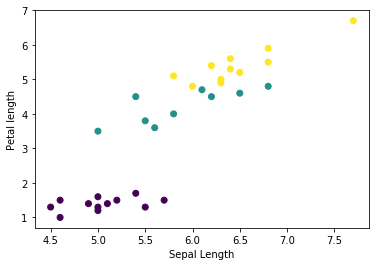

In [15]:
plt.scatter(features['sepal_length'], features['petal_length'], c=labels, cmap='viridis')
plt.xlabel('Sepal Length')
plt.ylabel('Petal length')
plt.show()

To simply the model building step, create a function to repackage the features dictionary into a single array `(batch_size, num_features)`.

In [0]:
def pack_features_vector(features, labels):
  features = tf.stack(list(features.values()), axis=1)
  return features, labels

You can pack a batch of the dataset via the `map` function.

In [0]:
train_dataset = train_dataset.map(pack_features_vector)

In [26]:
features, labels = next(iter(train_dataset))
features[:5], labels[:5]

(<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
 array([[5.9, 3.2, 4.8, 1.8],
        [5.1, 3.5, 1.4, 0.3],
        [5.4, 3.9, 1.3, 0.4],
        [5.8, 2.6, 4. , 1.2],
        [4.8, 3.1, 1.6, 0.2]], dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=int32, numpy=array([1, 0, 0, 1, 0], dtype=int32)>)

# Building the Model

A model is a relationship between features and the label.

## Create a Model via the `tf.keras` APIs

In [0]:
def create_model():
  def build_model(inputs):
    x = tf.keras.layers.Dense(units=10, activation='relu', input_shape=[4])(inputs)
    x = tf.keras.layers.Dense(units=10, activation='relu')(x)
    y = tf.keras.layers.Dense(units=3)(x)
    return y
  
  inputs = tf.keras.Input(shape=[4])
  outputs = build_model(inputs)
  model = tf.keras.Model(inputs, outputs)
  return model

model = create_model()

## Using the Model

In [29]:
predictions = model(features)
predictions[:5]

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[ 4.7798166 , -1.9261738 ,  0.32899243],
       [ 2.5004098 , -1.131138  ,  0.39268482],
       [ 2.7444267 , -1.2340019 ,  0.37218863],
       [ 3.5106628 , -1.3999825 ,  0.47025305],
       [ 2.3121128 , -1.0629119 ,  0.41465998]], dtype=float32)>

Here, each example returns a logit for each class. To convert the logit values to probability values using `tf.nn.softmax()` method.

In [36]:
probs = tf.nn.softmax(predictions[:5])
probs

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.9872716 , 0.00120799, 0.01152042],
       [0.87108827, 0.02306221, 0.10584949],
       [0.8992913 , 0.01683026, 0.08387846],
       [0.9477029 , 0.00698242, 0.04531469],
       [0.8444752 , 0.02889564, 0.12662913]], dtype=float32)>

To get the label using the `tf.argmax` method.

In [38]:
print("Predictions: {}".format(tf.argmax(probs, axis=1)))
print("Labels: {}".format(labels[:5]))

Predictions: [0 0 0 0 0]
Labels: [1 0 0 1 0]


# Training the Model

Training is a process where the weights in a model are optimized.

## Define the Loss and Gradient Functions

The loss function uncovers how bad the model is performing. We are going to minimize or optimize this loss value.

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [58]:
def loss(model, x, y, training):
  # training={True|False} is required for some layers, e.g. Dropout, etc.
  y_ = model(x, training=training)
  return loss_object(y_true=y, y_pred=y_)

l = loss(model, features, labels, training=False)
print("Loss test: {}".format(l))

Loss test: 2.707630157470703


In [0]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  grads = tape.gradient(loss_value, model.trainable_variables)
  return loss_value, grads

## Creating an Optimizer

An optimizer applied the gradients to model's weights to minimize the loss value.

In [0]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

In [62]:
loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(
  optimizer.iterations.numpy(),
  loss_value.numpy()
))

optimizer.apply_gradients(zip(grads, model.trainable_variables))

print("Step: {}, Initial Los: {}".format(
  optimizer.iterations.numpy(),
  loss(model, features, labels, training=True).numpy()
))

Step: 0, Initial Loss: 2.707630157470703
Step: 1, Initial Los: 2.1788220405578613


## Training Loop

The training loop feeds the dataset into the model to make better predictions.

In [65]:
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

for epoch in range(num_epochs):
  epoch_loss_avg.reset_states()
  epoch_accuracy.reset_states()

  for x, y in train_dataset:
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    epoch_loss_avg(loss_value)
    epoch_accuracy(y, model(x, training=True))

  # end epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print("Epoch: {}, Loss: {:.3f}, Accuracy: {:.3%}".format(
      epoch, train_loss_results[-1], train_accuracy_results[-1]))

Epoch: 0, Loss: 1.175, Accuracy: 31.667%
Epoch: 50, Loss: 0.422, Accuracy: 92.500%
Epoch: 100, Loss: 0.228, Accuracy: 96.667%
Epoch: 150, Loss: 0.163, Accuracy: 96.667%
Epoch: 200, Loss: 0.123, Accuracy: 97.500%


## Visualize the Loss Function Over Time

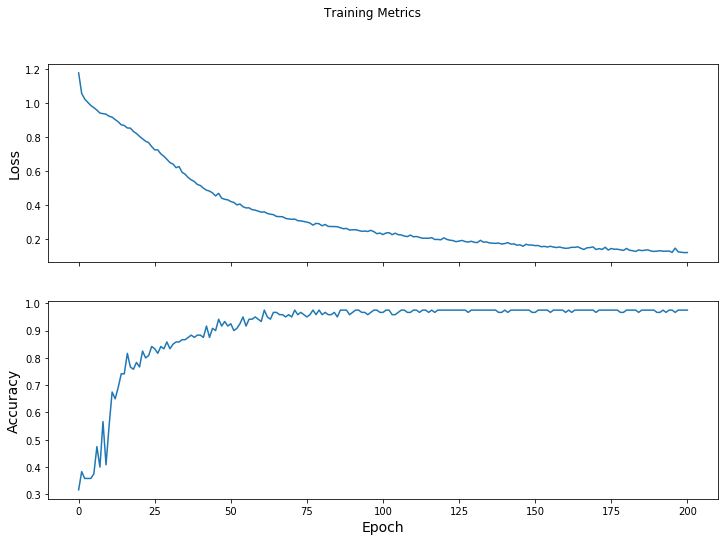

In [67]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle("Training Metrics")
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)
axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

# Evaluate the Model

The biggest difference between the training and the evaluation process is the dataset. The evaluation dataset is totally unseen before.

## Setup the Test Dataset

In [68]:
test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url), origin=test_url)
test_fp

8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


'/root/.keras/datasets/iris_test.csv'

In [69]:
eval_dataset = tf.data.experimental.make_csv_dataset(
  test_fp, batch_size=batch_size, column_names=column_names, label_name=label_name,
  num_epochs=1, shuffle=False)
eval_dataset

<PrefetchDataset shapes: (OrderedDict([(sepal_length, (None,)), (sepal_width, (None,)), (petal_length, (None,)), (petal_width, (None,))]), (None,)), types: (OrderedDict([(sepal_length, tf.float32), (sepal_width, tf.float32), (petal_length, tf.float32), (petal_width, tf.float32)]), tf.int32)>

In [0]:
eval_dataset = eval_dataset.map(pack_features_vector)

In [71]:
test_accuracy = tf.keras.metrics.Accuracy()

for x, y in eval_dataset:
  y_ = model(x, training=False)
  y_ = tf.argmax(y_, axis=1, output_type=tf.int32)
  test_accuracy(y, y_)

print("Test Dataset Accuracy: {}".format(test_accuracy.result()))

Test Dataset Accuracy: 0.9666666388511658


In [0]:
tf.stack([y, y_], axis=1)

# Predictions

Now let's predict several unlabelled data.

In [0]:
predicted_dataset = tf.convert_to_tensor([
  [5.1, 3.3, 1.7, 0.5,],
  [5.9, 3.0, 4.2, 1.5,],
  [6.9, 3.1, 5.4, 2.1]  
])

In [0]:
predictions = model(predicted_dataset, training=False)

In [76]:
for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("Example {} predictions: {} ({:4.1%})".format(i, name, p))

Example 0 predictions: Setosa (96.9%)
Example 1 predictions: Versicolor (84.7%)
Example 2 predictions: Virginica (82.8%)
